# Final model = XGB with feature(Morgan+Descriptor)

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import clone
from sklearn.model_selection import KFold


import selfies as sf

from rdkit import Chem, DataStructs
from rdkit.Chem import rdFingerprintGenerator, MACCSkeys, Descriptors

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, GCNConv, GINEConv, NNConv

from transformers import AutoTokenizer, AutoModel

import matplotlib.pyplot as plt
from matplotlib import MatplotlibDeprecationWarning

import warnings

warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)


warnings.filterwarnings(
    "ignore",
    message=".*'squared' is deprecated.*",
    category=FutureWarning
)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from function_for_small_dataset import (

    # data
    load_and_clean_csv_all,
    rdkit_mol_valid_mask_all,
    build_rdkit_feature_blocks_all,

    # scheme-2
    make_train_test_indices,
    slice_targets_by_idx,
    fit_binary_feature_filter_on_train,
    apply_mask_and_slice,
    fit_desc_filter_and_scaler_on_train,
    apply_desc_filter_and_scaler,
    fit_selfies_tfidf_on_train,
    build_feature_sets_9,
    

    # models
    get_model_zoo,

    # stacking + cv
    strict_stacking_gap_one_seed,
    cv_gap_model_strict,
)

In [2]:
# ====== USER CONFIG ======
csv_path = "41597_2016_BFsdata201686_MOESM94_ESM.csv"
smiles_col = "smiles"
targets = ["homo", "lumo", "gap"]


DESC_FUNCS = [
    ("MolWt", Descriptors.MolWt),
    ("MolLogP", Descriptors.MolLogP),
    ("TPSA", Descriptors.TPSA),
    ("NumHDonors", Descriptors.NumHDonors),
    ("NumHAcceptors", Descriptors.NumHAcceptors),
    ("NumRotatableBonds", Descriptors.NumRotatableBonds),
    ("RingCount", Descriptors.RingCount),
    ("NumAromaticRings", Descriptors.NumAromaticRings),
    ("HeavyAtomCount", Descriptors.HeavyAtomCount),
    ("FractionCSP3", Descriptors.FractionCSP3),
]

# ====== A1 load + clean ======
df_clean = load_and_clean_csv_all(
    csv_path=csv_path,
    smiles_col=smiles_col,
    targets=targets,
    drop_duplicates=True
)

# ====== A2 RDKit valid ======
mols_all, valid_mask, df_all_v, mols_all_v = rdkit_mol_valid_mask_all(
    df_clean,
    smiles_col=smiles_col
)

# ====== A3 RDKit feature blocks (robust unpack) ======
out = build_rdkit_feature_blocks_all(mols_all_v, DESC_FUNCS)

# possible returns:
# (X_morgan_base, X_morgan_var, X_maccs, X_desc_raw, desc_names)  OR
# (X_morgan_base, X_maccs, X_desc_raw, desc_names)
if len(out) == 5:
    X_morgan_base_all, X_morgan_var_all, X_maccs_all, X_desc_raw_all, desc_names = out
elif len(out) == 4:
    X_morgan_base_all, X_maccs_all, X_desc_raw_all, desc_names = out
    X_morgan_var_all = None
else:
    raise RuntimeError(f"Unexpected return length from build_rdkit_feature_blocks_all: {len(out)}")

print("df_all_v:", df_all_v.shape)
print("Morgan base:", X_morgan_base_all.shape)
print("MACCS:", X_maccs_all.shape)
print("Desc raw:", X_desc_raw_all.shape)
print("desc_names:", len(desc_names))

Dropped 0 duplicate SMILES
=== load_and_clean_csv_all ===
CSV: 41597_2016_BFsdata201686_MOESM94_ESM.csv
SMILES column: smiles
Targets: ['homo', 'lumo', 'gap']
Final molecule count: 316
RDKit valid molecules: 316 / 316
FULL RDKit feature blocks (scheme-2 ALL step):
  N molecules : 316
  Morgan base : (316, 1024)
  Morgan var  : (316, 2048)
  MACCS       : (316, 167)
  Desc(raw)   : (316, 10)
  desc_names  : 10
df_all_v: (316, 4)
Morgan base: (316, 1024)
MACCS: (316, 167)
Desc raw: (316, 10)
desc_names: 10


A strict stacked learning framework with nested cross-validation was employed to evaluate whether predicted frontier orbital energies improve bandgap regression. For each outer fold, all feature transformations were fitted exclusively on the training set. Within this outer training split, an inner K-fold procedure generated out-of-fold predictions for HOMO and LUMO, from which HOMO, LUMO, and their difference (Δ) were constructed as stacking features. These meta-features were concatenated with the original molecular descriptors and used to train the gap regressor. Direct and stacked gap models were evaluated on the held-out outer test fold, ensuring that no information leakage occurred at any stage. This nested design guarantees that any performance gain from stacking arises from learned electronic correlations rather than data leakage.

In [3]:
def strict_stacked_cv_gap_xgb_morgan_desc(
    df_all_v,
    smiles_col,
    targets,
    X_morgan_base_all,
    X_maccs_all,
    X_desc_raw_all,
    desc_names,
    gap_combo="XGB + Morgan+Desc",
    homo_combo="XGB + Morgan+MACCS+Desc",
    lumo_combo="LightGBM + Morgan+MACCS+Desc",
    kfold_outer=5,
    kfold_inner=5,
    seed=0,
    max_zero_frac=0.99,
    var_thresh=1e-12,
    corr_thresh=0.95,
    pca_dim=100,
):
    """
    Outer KFold: evaluate strict stacked generalization.
    Inner KFold: OOF preds (HOMO/LUMO) only on outer-train to build meta-features.
    Gap model is evaluated both direct and stacked (augmented with OOF-based meta feats).
    """

    def _rmse(y, p):
        return mean_squared_error(y, p, squared=False)

    def _metrics(y, p):
        return {
            "R2": float(r2_score(y, p)),
            "RMSE": float(_rmse(y, p)),
            "MAE": float(mean_absolute_error(y, p)),
        }

    def _parse_combo(combo_str):
        if not isinstance(combo_str, str) or " + " not in combo_str:
            raise ValueError(f"Bad combo: {combo_str!r}")
        m, f = combo_str.split(" + ", 1)
        return m.strip(), f.strip()

    def _safe_clone(est):
        try:
            return clone(est)
        except Exception:
            return est.__class__(**est.get_params())

    # ---- y (whole dataset)
    y_h_all = df_all_v["homo"].values
    y_l_all = df_all_v["lumo"].values
    y_g_all = df_all_v["gap"].values
    N = len(df_all_v)

    outer = KFold(n_splits=kfold_outer, shuffle=True, random_state=seed)

    rows = []
    bundles = {}

    # parse once
    gap_model_name, gap_feat_name   = _parse_combo(gap_combo)
    homo_model_name, homo_feat_name = _parse_combo(homo_combo)
    lumo_model_name, lumo_feat_name = _parse_combo(lumo_combo)

    for fold, (idx_tr, idx_te) in enumerate(outer.split(np.arange(N))):
        idx_tr = np.asarray(idx_tr, dtype=int)
        idx_te = np.asarray(idx_te, dtype=int)

        # =========================
        # strict per-fold transforms
        # =========================

        # Morgan
        keep_m = fit_binary_feature_filter_on_train(
            X_morgan_base_all,
            idx_tr,
            zero_var=True,
            max_zero_frac=max_zero_frac,
        )
        Xtr_m, Xte_m = apply_mask_and_slice(X_morgan_base_all, idx_tr, idx_te, keep_m)

        # MACCS
        keep_mac = fit_binary_feature_filter_on_train(
            X_maccs_all,
            idx_tr,
            zero_var=True,
            max_zero_frac=max_zero_frac,
        )
        Xtr_mac, Xte_mac = apply_mask_and_slice(X_maccs_all, idx_tr, idx_te, keep_mac)

        # Descriptors (fit on train only)
        tmp = fit_desc_filter_and_scaler_on_train(
            X_desc_raw_all,
            idx_tr,
            desc_names,
            var_thresh=var_thresh,
            corr_thresh=corr_thresh,
        )
        if (tmp is None) or (not isinstance(tmp, tuple)) or (len(tmp) != 3):
            raise RuntimeError(
                "fit_desc_filter_and_scaler_on_train returned invalid value "
                f"(expected 3-tuple, got {type(tmp)}: {tmp}). "
                "This usually means you're still running an older function version "
                "or a code path without 'return'."
            )

        keep_idx_desc, kept_desc_names, scaler_desc = tmp

        tmp2 = apply_desc_filter_and_scaler(
            X_desc_raw_all, idx_tr, idx_te, keep_idx_desc, scaler_desc
        )
        if (tmp2 is None) or (not isinstance(tmp2, tuple)) or (len(tmp2) != 2):
            raise RuntimeError(
                "apply_desc_filter_and_scaler returned invalid value "
                f"(expected 2-tuple, got {type(tmp2)}: {tmp2})."
            )
        Xtr_desc_s, Xte_desc_s = tmp2

        # =========================
        # build ONLY needed feature matrices
        # =========================
        # These are the only two feature names used by your combos:
        # gap_combo  -> Morgan+Desc
        # homo/lumo  -> Morgan+MACCS+Desc

        Xtr_MorganDesc = np.hstack([Xtr_m, Xtr_desc_s])
        Xte_MorganDesc = np.hstack([Xte_m, Xte_desc_s])

        Xtr_MorganMACCSDesc = np.hstack([Xtr_m, Xtr_mac, Xtr_desc_s])
        Xte_MorganMACCSDesc = np.hstack([Xte_m, Xte_mac, Xte_desc_s])

        feature_sets = {
            "Morgan+Desc": (Xtr_MorganDesc, Xte_MorganDesc),
            "Morgan+MACCS+Desc": (Xtr_MorganMACCSDesc, Xte_MorganMACCSDesc),
        }

        # =========================
        # models
        # =========================
        models = get_model_zoo(seed=seed, pca_dim=pca_dim)

        # sanity
        for mn in [gap_model_name, homo_model_name, lumo_model_name]:
            if mn not in models:
                raise KeyError(f"Model '{mn}' not found in get_model_zoo keys: {list(models.keys())}")

        for fn in [gap_feat_name, homo_feat_name, lumo_feat_name]:
            if fn not in feature_sets:
                raise KeyError(f"Feature '{fn}' not found. Available: {list(feature_sets.keys())}")

        # matrices for this fold
        Xtr_g, Xte_g = feature_sets[gap_feat_name]
        Xtr_h, Xte_h = feature_sets[homo_feat_name]
        Xtr_l, Xte_l = feature_sets[lumo_feat_name]

        ytr_h = y_h_all[idx_tr]
        ytr_l = y_l_all[idx_tr]
        ytr_g = y_g_all[idx_tr]
        yte_g = y_g_all[idx_te]

        # =========================
        # inner OOF on outer-train
        # =========================
        inner = KFold(n_splits=kfold_inner, shuffle=True, random_state=seed + fold + 123)

        homo_oof = np.zeros(len(idx_tr), dtype=float)
        lumo_oof = np.zeros(len(idx_tr), dtype=float)

        # IMPORTANT: inner split uses positions in outer-train arrays (0..len(idx_tr)-1)
        for tr2, va2 in inner.split(np.arange(len(idx_tr))):
            mh = _safe_clone(models[homo_model_name])
            mh.fit(Xtr_h[tr2], ytr_h[tr2])
            homo_oof[va2] = mh.predict(Xtr_h[va2])

            ml = _safe_clone(models[lumo_model_name])
            ml.fit(Xtr_l[tr2], ytr_l[tr2])
            lumo_oof[va2] = ml.predict(Xtr_l[va2])

        # full-train predictions for outer-test
        mh_full = _safe_clone(models[homo_model_name])
        mh_full.fit(Xtr_h, ytr_h)
        homo_te = mh_full.predict(Xte_h)

        ml_full = _safe_clone(models[lumo_model_name])
        ml_full.fit(Xtr_l, ytr_l)
        lumo_te = ml_full.predict(Xte_l)

        Ztr = np.column_stack([homo_oof, lumo_oof, (lumo_oof - homo_oof)])
        Zte = np.column_stack([homo_te,  lumo_te,  (lumo_te  - homo_te )])

        # =========================
        # gap: direct vs stacked
        # =========================
        est_gap = models[gap_model_name]

        m_direct = _safe_clone(est_gap)
        m_direct.fit(Xtr_g, ytr_g)
        pred_direct = m_direct.predict(Xte_g)

        m_stack = _safe_clone(est_gap)
        m_stack.fit(np.hstack([Xtr_g, Ztr]), ytr_g)
        pred_stacked = m_stack.predict(np.hstack([Xte_g, Zte]))

        md = _metrics(yte_g, pred_direct)
        ms = _metrics(yte_g, pred_stacked)

        rows.append({
            "fold": fold,
            "n_train": int(len(idx_tr)),
            "n_test": int(len(idx_te)),
            "gap_combo": gap_combo,
            "homo_combo": homo_combo,
            "lumo_combo": lumo_combo,
            "R2_direct": md["R2"],
            "RMSE_direct": md["RMSE"],
            "MAE_direct": md["MAE"],
            "R2_stacked": ms["R2"],
            "RMSE_stacked": ms["RMSE"],
            "MAE_stacked": ms["MAE"],
            "Delta_stack_vs_direct": ms["R2"] - md["R2"],
        })

        bundles[fold] = {
            "idx_tr": idx_tr,
            "idx_te": idx_te,
            "yte_gap": yte_g,
            "pred_direct": pred_direct,
            "pred_stacked": pred_stacked,
        }

    df_folds = pd.DataFrame(rows).sort_values("R2_stacked", ascending=False).reset_index(drop=True)

    # best / worst by stacked R2
    best_fold = int(df_folds.iloc[0]["fold"])
    worst_fold = int(df_folds.iloc[-1]["fold"])
    df_folds["rank_by_stacked"] = range(1, len(df_folds) + 1)
    df_folds["tag"] = ""
    df_folds.loc[df_folds["fold"] == best_fold, "tag"] = "BEST"
    df_folds.loc[df_folds["fold"] == worst_fold, "tag"] = "WORST"

    metric_cols = ["R2_direct","RMSE_direct","MAE_direct","R2_stacked","RMSE_stacked","MAE_stacked","Delta_stack_vs_direct"]
    summary = (
        df_folds[metric_cols]
        .agg(["mean","std","min","max"])
        .T.reset_index()
        .rename(columns={"index":"metric"})
    )

    return df_folds, summary, bundles[best_fold], bundles[worst_fold]


# ====== RUN IT ======
df_folds, summary, best_bundle, worst_bundle = strict_stacked_cv_gap_xgb_morgan_desc(
    df_all_v=df_all_v,
    smiles_col=smiles_col,
    targets=targets,
    X_morgan_base_all=X_morgan_base_all,
    X_maccs_all=X_maccs_all,
    X_desc_raw_all=X_desc_raw_all,
    desc_names=desc_names,
    gap_combo="XGB + Morgan+Desc",
    homo_combo="XGB + Morgan+MACCS+Desc",
    lumo_combo="LightGBM + Morgan+MACCS+Desc",
    kfold_outer=5,
    kfold_inner=5,
    seed=7,
)

print("Per-fold results (sorted by R2_stacked):")
display(df_folds)

print("\nSummary:")
display(summary)

Per-fold results (sorted by R2_stacked):


,fold,n_train,n_test,gap_combo,homo_combo,lumo_combo,R2_direct,RMSE_direct,MAE_direct,R2_stacked,RMSE_stacked,MAE_stacked,Delta_stack_vs_direct,rank_by_stacked,tag
0,0,252,64,XGB + Morgan+Desc,XGB + Morgan+MACCS+Desc,LightGBM + Morgan+MACCS+Desc,0.855832,0.009761,0.006720,0.849881,0.009960,0.007189,-0.005951,1,BEST
1,3,253,63,XGB + Morgan+Desc,XGB + Morgan+MACCS+Desc,LightGBM + Morgan+MACCS+Desc,0.789062,0.011861,0.007443,0.798739,0.011586,0.007336,0.009678,2,
2,4,253,63,XGB + Morgan+Desc,XGB + Morgan+MACCS+Desc,LightGBM + Morgan+MACCS+Desc,0.810889,0.012416,0.008063,0.762574,0.013911,0.008950,-0.048315,3,
3,2,253,63,XGB + Morgan+Desc,XGB + Morgan+MACCS+Desc,LightGBM + Morgan+MACCS+Desc,0.717129,0.015989,0.010066,0.727185,0.015702,0.009841,0.010056,4,
4,1,253,63,XGB + Morgan+Desc,XGB + Morgan+MACCS+Desc,LightGBM + Morgan+MACCS+Desc,0.724515,0.009689,0.006599,0.726787,0.009649,0.007130,0.002272,5,WORST



Summary:


,metric,mean,std,min,max
0,R2_direct,0.779485,0.058772,0.717129,0.855832
1,RMSE_direct,0.011943,0.002571,0.009689,0.015989
2,MAE_direct,0.007778,0.001409,0.006599,0.010066
3,R2_stacked,0.773033,0.052241,0.726787,0.849881
4,RMSE_stacked,0.012162,0.002602,0.009649,0.015702
5,MAE_stacked,0.008089,0.001236,0.007130,0.009841
6,Delta_stack_vs_direct,-0.006452,0.024298,-0.048315,0.010056


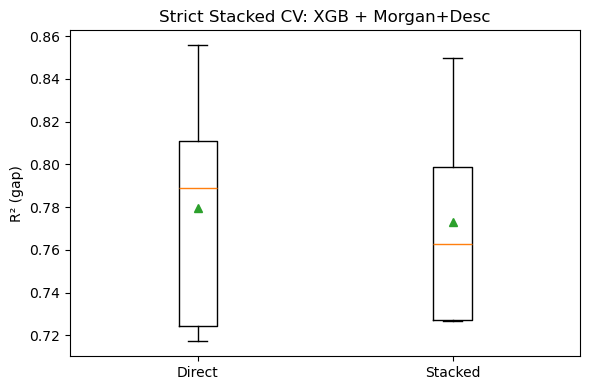

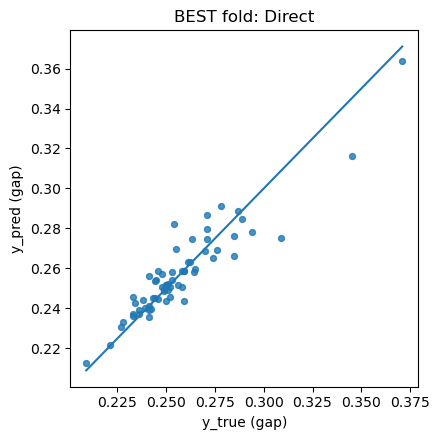

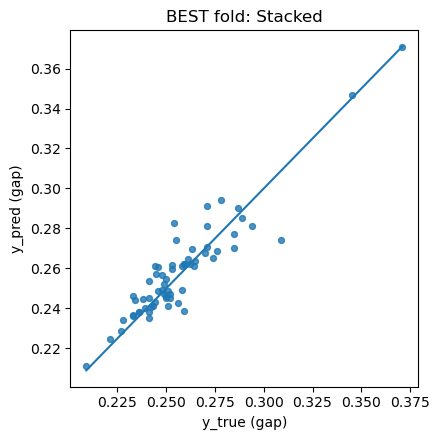

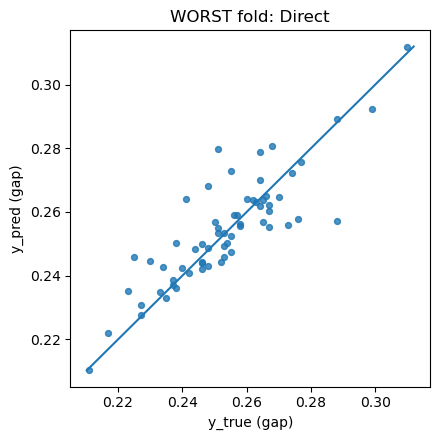

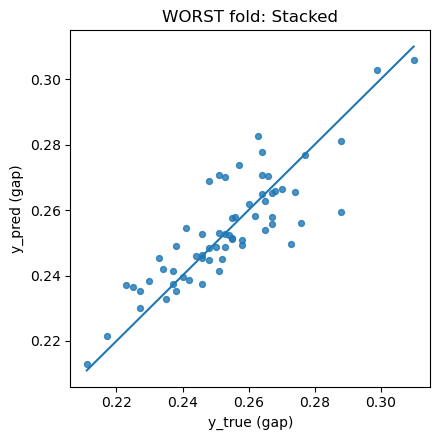

In [4]:


plt.figure(figsize=(6,4))
plt.boxplot(
    [df_folds["R2_direct"].values, df_folds["R2_stacked"].values],
    labels=["Direct", "Stacked"],
    showmeans=True
)
plt.ylabel("R² (gap)")
plt.title("Strict Stacked CV: XGB + Morgan+Desc")
plt.tight_layout()
plt.show()

def _scatter_true_pred(y, p, title):
    plt.figure(figsize=(4.5,4.5))
    plt.scatter(y, p, s=18, alpha=0.8)
    mn = min(np.min(y), np.min(p))
    mx = max(np.max(y), np.max(p))
    plt.plot([mn, mx], [mn, mx])
    plt.xlabel("y_true (gap)")
    plt.ylabel("y_pred (gap)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

_scatter_true_pred(best_bundle["yte_gap"], best_bundle["pred_direct"],  "BEST fold: Direct")
_scatter_true_pred(best_bundle["yte_gap"], best_bundle["pred_stacked"], "BEST fold: Stacked")

_scatter_true_pred(worst_bundle["yte_gap"], worst_bundle["pred_direct"],  "WORST fold: Direct")
_scatter_true_pred(worst_bundle["yte_gap"], worst_bundle["pred_stacked"], "WORST fold: Stacked")